In [1]:
import os
import pyspark
import re
from pyspark.sql.functions import col, column, size
from pyspark.sql.types import StringType, IntegerType


conf = pyspark.SparkConf()

conf.set('spark.ui.proxyBase', '/user/' + os.environ['JUPYTERHUB_USER'] + '/proxy/4041')
conf.set('spark.sql.repl.eagerEval.enabled', True)
conf.set('spark.driver.memory','8g')
conf.set("spark.sql.caseSensitive", "true")
sc = pyspark.SparkContext(conf=conf)

spark = pyspark.SQLContext.getOrCreate(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 19:15:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/envs/bigdata/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Dataset: https://nijianmo.github.io/amazon/index.html
# As we discussed this link has 2 types of data a subset version which has very few rows for each category.
# There is no point of using these data.
# It also has the normal dataset (Complete review data)
# If you click on either the reviews or metadata links on any category 
# It will take you on a Google form if you complete it will 
# send you here http://deepyeti.ucsd.edu/jianmo/amazon/ 
# From here you can download any file for whatever category you want
# No need, however, we can just download it straight to jupyter (see below)

In [ ]:
# If you download the same file many times it will just create copies in your home directory
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Software.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Software.json.gz

## Importing the Data

In [2]:
products = spark.read.json("meta_Software.json.gz")
reviews = spark.read.json("Software.json.gz")

22/05/17 19:16:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Understanding the Data

In [3]:
print((products.count(), len(products.columns)))
print((reviews.count(), len(reviews.columns)))

(26790, 19)


(459436, 12)


In [4]:
products.limit(5)

also_buy,also_view,asin,brand,category,date,description,details,feature,fit,imageURL,imageURLHighRes,main_cat,price,rank,similar_item,tech1,tech2,title
[],[],0030672120,HOLT. RINEHART AN...,[],</div>,[],null,[],,[],[],Software,.a-box-inner{back...,"25,550 in Software (",,,,HOLT PHYSICS LESS...
[],[],0071480935,McGraw Hill,[],</div>,"[, <b>Latin rhyth...",null,[],,[https://images-n...,[https://images-n...,Software,,"15,792 in Software (",,,,"Sing, Watch, &amp..."
[],[],007329506X,McGraw-Hill Scien...,[],</div>,[<b>Connect is th...,null,[],,[https://images-n...,[https://images-n...,Software,,"16,900 in Software (",,,,Connect with Lear...
[],[],0073513458,McGraw-Hill Educa...,[],</div>,[],null,[],,[https://images-n...,[https://images-n...,Software,,"12,986 in Software (",,,,LearnSmart Standa...
"[0323394612, 0323...",[],0073525758,McGraw-Hill Educa...,[],</div>,[<i>Anatomy &amp;...,null,[],,[https://images-n...,[https://images-n...,Software,$4.83,"14,861 in Software (",,,,Anatomy &amp; Phy...


In [5]:
reviews.limit(5)

asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0077613252,null,4.0,The materials arr...,"03 11, 2014",A240ORQ2LF9LUI,Michelle W,"{null, Loose Lea...",Material Great,1394496000,true,null
0077613252,null,4.0,I am really enjoy...,"02 23, 2014",A1YCCU0YRLS0FE,Rosalind White Ames,"{null, Loose Lea...",Health,1393113600,true,null
0077613252,null,1.0,IF YOU ARE TAKING...,"02 17, 2014",A1BJHRQDYVAY2J,Allan R. Baker,"{null, Loose Lea...",ARE YOU KIDING ME?,1392595200,true,7
0077613252,null,3.0,This book was mis...,"02 17, 2014",APRDVZ6QBIQXT,Lucy,"{null, Loose Lea...",missing pages!!,1392595200,true,3
0077775473,null,5.0,I have used Learn...,"10 14, 2013",A2JZTTBSLS1QXV,Albert V.,null,Best study produc...,1381708800,false,null


In [6]:
reviews.describe().toPandas()

,summary,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,vote
0,count,459436,459436,459370,459436,459436,459412,459380,459436,127853
1,mean,1.6536614548992403E9,3.5701751712969814,1.619047619047619,None,None,NaN,1684.151219512195,1.369690838436692E9,10.399738727744923
2,stddev,1.403284353677117E9,1.6266620188688528,2.108937895628756,None,None,NaN,3680.707733175914,1.150168095078268E8,26.291150782486987
3,min,0030672120,1.0,"\n\nAs a loyal Quicken user since 1997, and on...","01 1, 2000",A00577669P2XCLU956L8,,,912729600,"1,028"
4,max,B01HJAMWOK,5.0,~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~...,"12 9, 2017",AZZYX9XK6MC8S,~me,~~~~~~~~~~~~~~~~ TT Makes a Taxing Experience...,1538438400,999


In [7]:
products.describe().toPandas()

,summary,asin,brand,date,fit,main_cat,price,rank,similar_item,tech1,tech2,title
0,count,26790,26790,26790,26790,26790,26790,26790,26790,26790,26790,26790
1,mean,1.867807794974587E9,1239382.02,None,None,None,None,None,None,None,None,11.0
2,stddev,1.7691138798705487E9,3559614.7783461586,None,None,None,None,None,None,None,None,None
3,min,0030672120,,,,,,"1,001 in Software (",,,,
4,max,B01HJAMWOK,yudu,TheMarketingPlanResource,,Video Games,.a-section.a-spacing-mini{margin-bottom:6px!im...,[],"class=""a-bordered a-horizontal-stripes a-spa...","class=""a-keyvalue prodDetTable"" role=""present...","class=""a-keyvalue prodDetTable"" role=""present...","yudu CardShop Screen, Filigree Frame"


## understanding the data schema

In [8]:
products.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Package Dimensions: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |--  Date first listed on Amazon:: string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio CD:: string (nullable = true)
 |    |-- Batteries: string (nullable = true)
 |    |

In [9]:
reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Hardware Platform:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Model Number:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Package Type:: string (nullable = true)
 |    |-- Platform:: string (nullable = true)
 |    |-- Product Packaging:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |    |-- style:: string (nullable = tru

## Cleaning the data

In [10]:
# Filter products that have values for category and feature columns as these will be used for content based filtering
products = products.where(size('category') > 0).where(size('feature') > 0)

In [11]:
# Only keep reviews for products that exits in the products dataframe
reviews = reviews.join(products, reviews["asin"] == products["asin"],"leftsemi")

In [12]:
# Remove Duplicate columns in both dataframes
reviews = reviews.dropDuplicates(["asin","reviewerID"])
products = products.dropDuplicates(["asin"])

In [13]:
# Keep the columns we want, and some renaming
products = products.drop("also_buy", "also_view","brand", "date","details","fit","imageURL","imageURLHighRes","rank","similar_item","tech1","tech2")

reviews = reviews.drop("image", "reviewTime","reviewText", "style","summary","unixReviewTime","verified","vote")

In [14]:
products = products.withColumnRenamed("asin","productID")\
    .withColumnRenamed("main_cat","main_category")\
    .withColumnRenamed("title","productName")\
    .withColumnRenamed("category","categories")

reviews = reviews.withColumnRenamed("asin","productID")\
    .withColumnRenamed("reviewerID","userID")

In [15]:
# userID and productID have to be integers in order for collaboration filtering to work
# simple cast to integer from string will not work as userID and productID contain alphanumeric characters.
# I know productID seems like it is only numbers but deep in the df there are rows with letters
# therefore we are using StringIndexer to create unique int ids for both

# userID transformation
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="userID", outputCol="intUserID")
reviews = indexer.fit(reviews).transform(reviews)

# cast from double to int
reviews = reviews.withColumn("intUserID",reviews['intUserID'].cast(IntegerType()))

In [16]:
# for productID tranformation the trick is to train the model with products dataframe
# then fit to both products and reviews
indexer = StringIndexer(inputCol="productID", outputCol="intProductID")
i = indexer.fit(products)

products = i.transform(products)
reviews = i.transform(reviews)

# cast from double to int
products = products.withColumn("intProductID",products['intProductID'].cast(IntegerType()))
reviews = reviews.withColumn("intProductID",reviews['intProductID'].cast(IntegerType()))

In [17]:
# Overall also has to be an integer but this can be done with a simple cast
reviews = reviews.withColumn("overall",reviews['overall'].cast(IntegerType()))

In [18]:
products.show(4)

+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+
| productID|          categories|         description|             feature|main_category|price|         productName|intProductID|
+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+
|0205064833|[Software, Progra...|[System Requireme...|[SAME FUNCTIONALI...|     Software|     |Microsoft FrontPa...|           1|
|031025888X|[Software, Educat...|[Powered by Pradi...|[Guided Tour of t...|     Software|     |NIV Student Bible...|           2|
|0310258928|[Software, Educat...|[Powered by Pradi...|[Unlimited space ...|     Software|     |The Zondervan NIV...|           3|
|0321506847|[Software, Busine...|                  []|[Microsoft Excel ...|     Software|     |Instructor's Reso...|           4|
+----------+--------------------+--------------------+--------------------+-------------+-

In [19]:
products.printSchema()

root
 |-- productID: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- feature: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_category: string (nullable = true)
 |-- price: string (nullable = true)
 |-- productName: string (nullable = true)
 |-- intProductID: integer (nullable = true)



In [20]:
reviews.show(2)

22/05/17 19:17:31 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


+----------+-------+--------------+--------------------+---------+------------+
| productID|overall|        userID|        reviewerName|intUserID|intProductID|
+----------+-------+--------------+--------------------+---------+------------+
|0131817949|      3|A2RETZJEDJB3GK| SJC History Teacher|   170618|           0|
|031025888X|      5|A1GQH2MCHKD4WG|Jolene A. Sagstetter|    71355|           2|
+----------+-------+--------------+--------------------+---------+------------+
only showing top 2 rows



In [21]:
reviews.printSchema()

root
 |-- productID: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- userID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- intUserID: integer (nullable = true)
 |-- intProductID: integer (nullable = true)



## Plotting Ratings v Count

/opt/conda/envs/bigdata/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


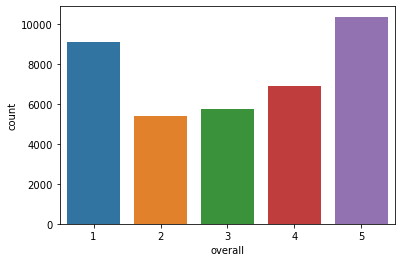

In [22]:
import seaborn as sns

#grouping data based on ratings(overall) and productID

temp_df=reviews.groupBy('overall', 'productID').count().toPandas()
temp_df.head(4)

sns.countplot('overall', data=temp_df)

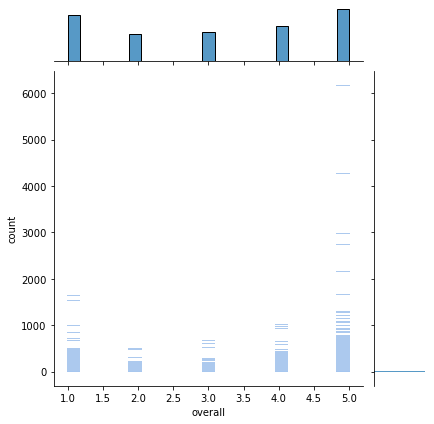

In [23]:
sns.jointplot(x="overall", y='count', kind='hist',data=temp_df)

## Pre-processing the data

In [24]:
from pyspark.sql.functions import regexp_replace, lower, udf
from pyspark.sql.types import ArrayType

In [25]:
from pyspark.sql.functions import concat_ws

# feature, categories are a list, so just concat all eklements of the list to a string
products = products.withColumn("categories", concat_ws(" ", "categories"))
products = products.withColumn("feature", concat_ws(" ", "feature"))

In [26]:
products.show(2)

+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+
| productID|          categories|         description|             feature|main_category|price|         productName|intProductID|
+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+
|0205064833|Software Programm...|[System Requireme...|SAME FUNCTIONALIT...|     Software|     |Microsoft FrontPa...|           1|
|031025888X|Software Educatio...|[Powered by Pradi...|Guided Tour of th...|     Software|     |NIV Student Bible...|           2|
+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+
only showing top 2 rows



## preprocess

In [27]:

from pyspark.sql.functions import col, lower, regexp_replace, split

def clean_text(c):
  c = lower(c)
  c = regexp_replace(c, "<p>", "")
  c = regexp_replace(c, "</p>", "")
  c = regexp_replace(c, "<code>", "")
  c = regexp_replace(c, "</code>", "")
  c = regexp_replace(c, "<strong>", "")
  c = regexp_replace(c, "</strong>", "")
  c = regexp_replace(c, "'ve", "")
  c = regexp_replace(c, "'m", "")
  c = regexp_replace(c, "'s", "")
  c = regexp_replace(c, "'t", "")
  c = regexp_replace(c, "<[^>]+>", "")
  c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
  c = regexp_replace(c, "(https?\://)\S+", "")
  c = regexp_replace(c, "^rt ", "")
  return c

In [28]:
products = products.withColumn("description",regexp_replace(lower(col("description")[0]),'[^0-9a-z]',' '))\
    .withColumn("description",regexp_replace(lower(col("description")),' +',' '))\
    .withColumn("description",regexp_replace(lower(col("description")),'^+| +& ',''))
products = products.where(col('description').isNotNull())

products = products.withColumn("categories",regexp_replace(lower(col("categories")),'[^0-9a-z]',' '))\
    .withColumn("categories",regexp_replace(lower(col("categories")),' +',' '))\
    .withColumn("categories",regexp_replace(lower(col("categories")),'^+| +& ',''))

products = products.withColumn("feature",regexp_replace(lower(col("feature")),'[^0-9a-z]',' '))\
    .withColumn("feature",regexp_replace(lower(col("feature")),' +',' '))\
    .withColumn("feature",regexp_replace(lower(col("feature")),'^+| +& ',''))

products = products.withColumn("productName",regexp_replace(lower(col("productName")),'[^0-9a-z]',' '))\
    .withColumn("productName",regexp_replace(lower(col("productName")),' +',' '))\
    .withColumn("productName",regexp_replace(lower(col("productName")),'^+| +& ',''))

In [29]:
from pyspark.sql.functions import concat, col, lit

# Finally combine columns
products = products.withColumn("combinedColumn",concat(col("productName"), lit(" "), col("categories")))
products = products.withColumn("combinedColumn",concat(col("combinedColumn"), lit(" "), col("feature")))
products = products.withColumn("combinedColumn",concat(col("combinedColumn"), lit(" "), col("description")))

## Tokenize combinedColumn into array of strings(tokens)

In [30]:

from pyspark.ml.feature import Tokenizer, RegexTokenizer

tokenizer = Tokenizer(inputCol="description", outputCol="tokens")
products = tokenizer.transform(products)

## Count frequency of each tokens and create vectors

In [31]:

from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="tokens", outputCol="vecTokens", minDF=1.0)

model = cv.fit(products)
products = model.transform(products)

In [32]:
products.show(2)

22/05/17 19:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1032.3 KiB


+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+--------------------+--------------------+--------------------+
| productID|          categories|         description|             feature|main_category|price|         productName|intProductID|      combinedColumn|              tokens|           vecTokens|
+----------+--------------------+--------------------+--------------------+-------------+-----+--------------------+------------+--------------------+--------------------+--------------------+
|0205064833|software programm...|system requiremen...|same functionalit...|     Software|     |microsoft frontpa...|           1|microsoft frontpa...|[system, requirem...|(37563,[0,5,6,7,1...|
|031025888X|software educatio...|powered by pradis...|guided tour of th...|     Software|     |niv student bible...|           2|niv student bible...|[powered, by, pra...|(37563,[1,6,18,36...|
+----------+--------------------+--

In [33]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(inputCol="vecTokens", outputCol="lsh", bucketLength=2, numHashTables=2)
model = brp.fit(products)    

## Find recommendations for this product

In [39]:

# Product Name: microsoft office

prod = products.where(col("intProductID") == 3000)
prod

22/05/17 20:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
22/05/17 20:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
22/05/17 20:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB
22/05/17 20:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1032.7 KiB


productID,categories,description,feature,main_category,price,productName,intProductID,combinedColumn,tokens,vecTokens
B0006I0WP4,software educatio...,microsoft office ...,learn the most po...,Software,,mavis beacon teac...,3000,mavis beacon teac...,"[microsoft, offic...","(37563,[1,2,3,5,9..."


In [41]:
prod.select('productID', 'description').show()

+----------+--------------------+
| productID|         description|
+----------+--------------------+
|B0006I0WP4|microsoft office ...|
+----------+--------------------+



In [40]:
# Find and display recommendations
model.approxSimilarityJoin(products, prod, 10, distCol="dist")\
    .select(col("datasetA.productName").alias("recommendedProduct"),col("datasetA.intProductID").alias("intProductID"),col("dist"))\
    .sort("dist").limit(5).show(truncate=50)


22/05/17 20:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1695.0 KiB
22/05/17 20:39:59 WARN DAGScheduler: Broadcasting large task binary with size 1875.1 KiB
22/05/17 20:40:19 WARN DAGScheduler: Broadcasting large task binary with size 1681.4 KiB


+--------------------------------------------------+------------+------------------+
|                                recommendedProduct|intProductID|              dist|
+--------------------------------------------------+------------+------------------+
|                    mavis beacon teaches office xp|        3000|               0.0|
|                           learn office essentials|        1980|6.4031242374328485|
|simon amp schuster walking with dinosaurs windo...|        1283|               7.0|
|                 tune transfer win mac jewel case |        4369| 7.211102550927978|
|pc treasures cluefinders 6th grade adventures n...|        8535| 7.280109889280518|
+--------------------------------------------------+------------+------------------+



22/05/17 20:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1655.6 KiB
